<a href="https://colab.research.google.com/github/Lacave91/Project-CNN/blob/main/transfer_learning_model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load and pre process **data**

In [3]:
import os
import zipfile
from google.colab import drive

# 📌 Step 1: Mount Google Drive
drive.mount('/content/drive')

# 📌 Step 2: Define Paths
animals_zip_path = "/content/drive/MyDrive/animals10.zip"  # Training + validation (90%)
holdout_zip_path = "/content/drive/MyDrive/holdout.zip"  # Holdout set (10%)

animals_extract_to = "/content/Animals-10/"
holdout_extract_to = "/content/Holdout-10/"

# 📌 Step 3: Extract the ZIP Files
if not os.path.exists(animals_extract_to):
    with zipfile.ZipFile(animals_zip_path, 'r') as zip_ref:
        zip_ref.extractall(animals_extract_to)
    print("✅ Extracted training dataset.")

if not os.path.exists(holdout_extract_to):
    with zipfile.ZipFile(holdout_zip_path, 'r') as zip_ref:
        zip_ref.extractall(holdout_extract_to)
    print("✅ Extracted holdout dataset.")

# 📌 Step 4: Fix Dataset Paths (Point to `raw-img/`)
animals_dataset_path = "/content/Animals-10/animals10/raw-img/"
holdout_dataset_path = "/content/Holdout-10/holdout/raw-img/"

# 📌 Step 5: Check Folder Structure
print("📂 Training Dataset Categories:", os.listdir(animals_dataset_path))
print("📂 Holdout Dataset Categories:", os.listdir(holdout_dataset_path))


Mounted at /content/drive
✅ Extracted training dataset.
✅ Extracted holdout dataset.
📂 Training Dataset Categories: ['sheep', 'spider', 'squirrel', 'cow', '.DS_Store', 'elephant', 'cat', 'dog', 'butterfly', 'chicken', 'horse']
📂 Holdout Dataset Categories: ['sheep', 'spider', 'squirrel', 'cow', '.DS_Store', 'elephant', 'cat', 'dog', 'butterfly', 'chicken', 'horse']


Check the folder structures

In [4]:
# List class folders
print("📂 Classes in Training Dataset:", os.listdir(animals_dataset_path))

# Print the class folders inside the holdout dataset
if os.path.exists(holdout_dataset_path):
    print("📂 Classes in Prediction (Holdout) Dataset:", os.listdir(holdout_dataset_path))
else:
    print("❌ Holdout dataset path not found:", holdout_dataset_path)


📂 Classes in Training Dataset: ['sheep', 'spider', 'squirrel', 'cow', '.DS_Store', 'elephant', 'cat', 'dog', 'butterfly', 'chicken', 'horse']
📂 Classes in Prediction (Holdout) Dataset: ['sheep', 'spider', 'squirrel', 'cow', '.DS_Store', 'elephant', 'cat', 'dog', 'butterfly', 'chicken', 'horse']


Normalize images, rescale and resize, train/validation split, one-hot encode is handled by imageDataGenerator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

# Normalize images and apply data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increase rotation
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    validation_split=0.2
)

# Load training data
train_generator = datagen.flow_from_directory(
    directory=animals_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_generator = datagen.flow_from_directory(
    directory=animals_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("Dataset successfully loaded!")


Found 18856 images belonging to 10 classes.
Found 4709 images belonging to 10 classes.
Dataset successfully loaded!


Plot 5 random images

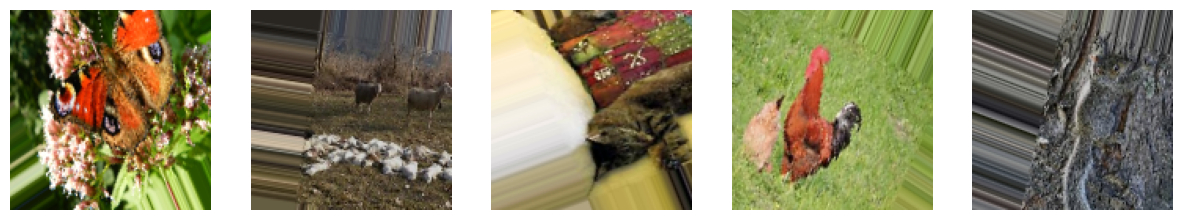

In [6]:
import matplotlib.pyplot as plt

# Get a batch of images
images, labels = next(train_generator)

# Display first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].axis("off")
plt.show()

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

# Load the pre-trained model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the entire convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Check the trainable state of each layer
for i, layer in enumerate(base_model.layers):
    print(f"{i}. {layer.name}: {layer.trainable}")

# Create a new model on top of VGG16
model = Sequential()

# Add VGG16 base model
model.add(base_model)

# Add the new classification layers
model.add(Flatten())


model.add(Dense(512, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(BatchNormalization())
model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(BatchNormalization())
model.add(Dense(128, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
0. input_layer: False
1. block1_conv1: False
2. block1_conv2: False
3. block1_pool: False
4. block2_conv1: False
5. block2_conv2: False
6. block2_pool: False
7. block3_conv1: False
8. block3_conv2: False
9. block3_conv3: True
10. block3_pool: True
11. block4_conv1: True
12. block4_conv2: True
13. block4_conv3: True
14. block4_pool: True
15. block5_conv1: True
16. block5_conv2: True
17. block5_conv3: True
18. block5_pool: True


In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
lr_schedule = LearningRateScheduler(lambda epoch: 1e-3 * 10**(-epoch / 20))
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Compile the model
fine_tune_lr = Adam(learning_rate=5e-5)
model.compile(loss='categorical_crossentropy', optimizer=fine_tune_lr, metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 146s 222ms/step - accuracy: 0.1199 - loss: 4.2724 - val_accuracy: 0.2495 - val_loss: 3.3364 - learning_rate: 5.0000e-05
Epoch 2/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 121s 205ms/step - accuracy: 0.1882 - loss: 3.7490 - val_accuracy: 0.2975 - val_loss: 3.1431 - learning_rate: 5.0000e-05
Epoch 3/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 121s 204ms/step - accuracy: 0.2490 - loss: 3.3922 - val_accuracy: 0.3444 - val_loss: 3.2580 - learning_rate: 5.0000e-05
Epoch 4/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 121s 205ms/step - accuracy: 0.3054 - loss: 3.0972 - val_accuracy: 0.3181 - val_loss: 3.0257 - learning_rate: 5.0000e-05
Epoch 5/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 120s 204ms/step - accuracy: 0.3229 - loss: 2.9530 - val_accuracy: 0.3323 - val_loss: 2.8377 - learning_rate: 5.0000e-05
Epoch 6/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 121s 205ms/step - accuracy: 0.3766 - loss: 2.7267 - val_accuracy: 0.5005 - val_loss: 2.2522 - learning_rate: 5.0000e-05
Epoch 7/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 

Define Model

# Evaluate Model Performance on Validation Set (NOT on Holdout)

148/148 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - accuracy: 0.8573 - loss: 0.8369
Validation Accuracy: 86.26%
Validation Loss: 0.8131
Training Accuracy: 89.66%
Training Loss: 0.6640


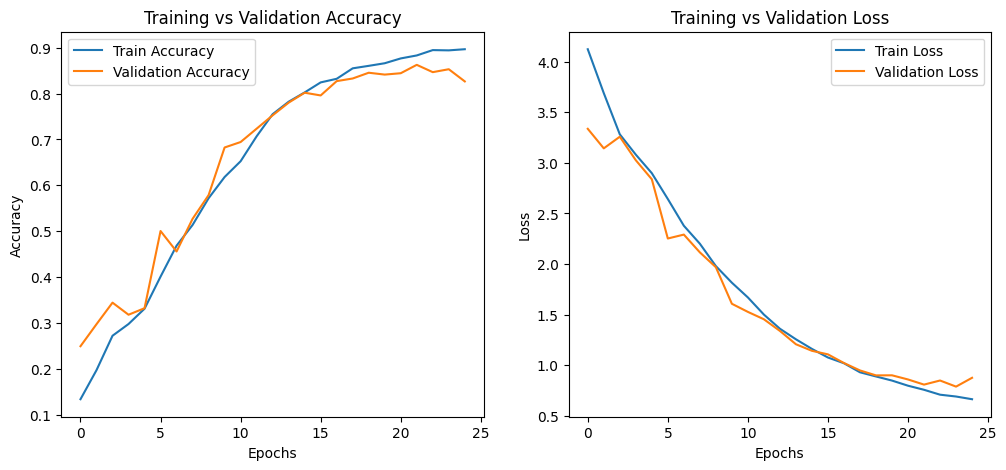

In [9]:
# 📌 Step 10: Evaluate the Model
loss, accuracy = model.evaluate(val_generator)

print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

# Get final training accuracy & loss
train_accuracy = history.history['accuracy'][-1]  # Last epoch's accuracy
train_loss = history.history['loss'][-1]  # Last epoch's loss

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# 📌 Step 11: Plot Accuracy & Loss Curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

plt.show()

In [ ]:
#Compute and report metrics such as  precision, recall, and F1-score.

Predict on validation set

In [10]:
import numpy as np

# Get true labels and predicted labels
y_true = []
y_pred = []

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Predict on the entire validation set
for images, labels in val_generator:
    predictions = model.predict(images)  # Get predictions
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot encoding to label index
    y_pred.extend(np.argmax(predictions, axis=1))  # Get highest probability class

    if len(y_true) >= val_generator.samples:  # Stop when all validation images are processed
        break


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

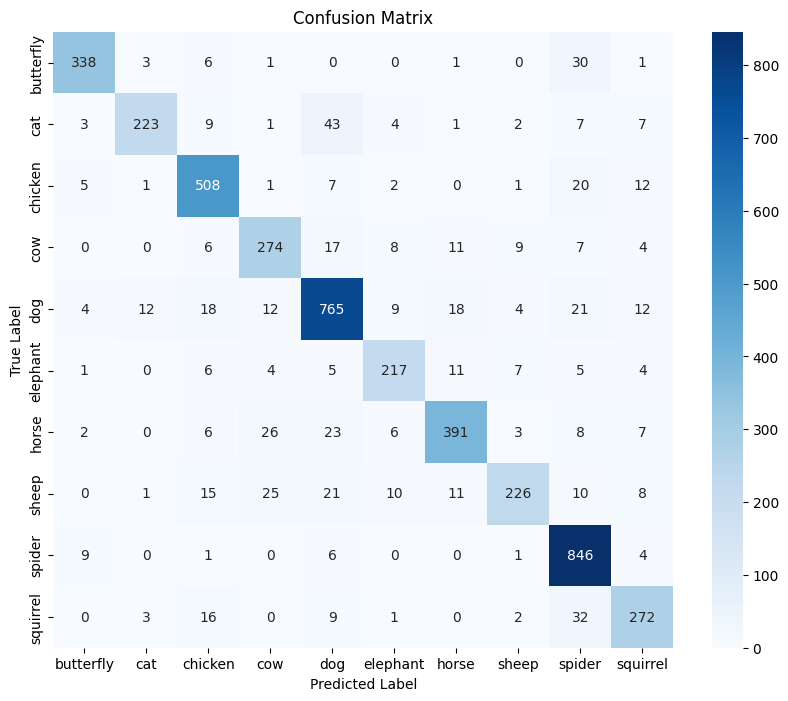

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Predict on Holdout Set (No Evaluation, Only Predictions)


✅ Making Predictions on Holdout Set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

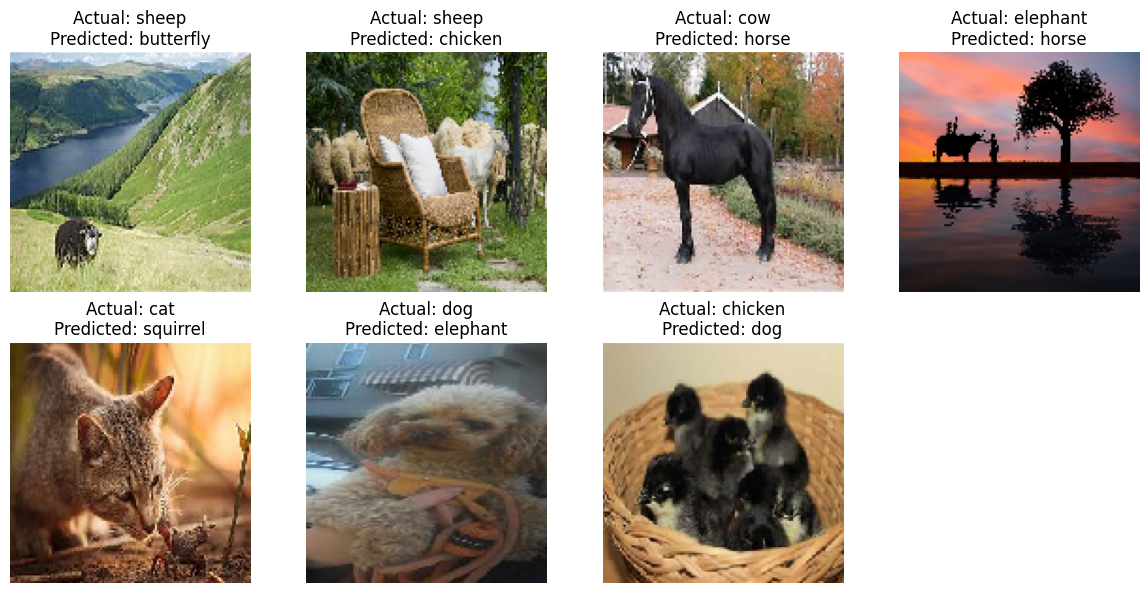

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

print("\n✅ Making Predictions on Holdout Set...")

class_labels = list(train_generator.class_indices.keys())

misclassified_images = []  # Store misclassified images

for class_name in os.listdir(holdout_dataset_path):
    class_folder = os.path.join(holdout_dataset_path, class_name)

    if os.path.isdir(class_folder):
        image_files = os.listdir(class_folder)

        for img_file in image_files[:5]:  # Predict on first 5 images
            if img_file.endswith(('.jpg', '.png', '.jpeg')):  # Ignore `.DS_Store`
                img_path = os.path.join(class_folder, img_file)

                # Load & Preprocess Image
                img = image.load_img(img_path, target_size=(128, 128))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array /= 255.0  # Normalize

                # Make Prediction
                prediction = model.predict(img_array)
                predicted_class = np.argmax(prediction)
                predicted_label = class_labels[predicted_class]

                # Check if misclassified
                if predicted_label != class_name:
                    misclassified_images.append((img_path, class_name, predicted_label))

# 📌 Step 2: Display Misclassified Images
if misclassified_images:
    print(f"\n❌ Found {len(misclassified_images)} Misclassified Images. Displaying...")

    plt.figure(figsize=(12, 6))
    for i, (img_path, actual, predicted) in enumerate(misclassified_images[:8]):  # Show first 8 misclassified images
        img = image.load_img(img_path, target_size=(128, 128))
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")

    plt.tight_layout()
    plt.show()
else:
    print("✅ No misclassified images found in the first few samples!")
